# Import necessary modules

In [59]:
import numpy as np
import pandas as pd
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM,Dense,Embedding
from sklearn.model_selection import train_test_split
import os
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [4]:
#importing the training data
dat_out_of_sample  = pd.read_csv('/home/dk/Downloads/email_classification/out_of_sample.csv')

In [5]:
#cleaning the text

REPLACE_BY_SPACE_RE = re.compile('[\/(){}\[\]\|@,;"#]')
BAD_SYMBOLS_RE = re.compile('[0-9#+_.:?!]')
LINKS = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)')

def text_prepare(text):
    text = re.sub(r'https:\/\/t\.co\/\w+', "", text)
    text = re.sub(LINKS, "", text)
    text = re.sub('<[^<]*?/?>', ' ', text)
    text = re.sub(r'["\'\"!|@$—%^&*(){};:,./<>?\|=_+-]', r' ', text)
    text = re.sub(REPLACE_BY_SPACE_RE, " ", text) 
    text = re.sub(BAD_SYMBOLS_RE, "", text) 
    text = re.sub(r'\\n', "", text) 
    text = re.sub(r'gt', "", text) 
    text = re.sub(r'amp', "", text)
    text = re.sub(' +', ' ',text)
    text = text.lower() 
    return text

In [6]:
#transforming and cleaning the data
dat_out_of_sample['text'] = dat_out_of_sample['MsgSubject'] + dat_out_of_sample['Body']
dat_out_of_sample = dat_out_of_sample[['text','Category ']].dropna()
dat_out_of_sample.index = np.arange(0,dat_out_of_sample.shape[0])
dat_out_of_sample.columns = ['text','category']
dat_out_of_sample['category'] = dat_out_of_sample['category'].apply(lambda x : x.lower())
dat_out_of_sample['text'] =  [text_prepare(dat_out_of_sample['text'][i]) for i in range(len(dat_out_of_sample['text']))]

In [7]:
dat_out_of_sample=dat_out_of_sample[~dat_out_of_sample.category.isin(['cc','additioanl service','options','error','spam'])]

In [8]:
dat_out_of_sample.head()

,text,category
0,rocco forte hotels your reservation confirmati...,vendor
1,rocco forte hotels your reservation confirmati...,vendor
2,rocco forte hotels your reservation confirmati...,vendor
3,passenger receipt confirmation of booking chif...,vendor
4,passenger receipt confirmation of booking wlb ...,vendor


In [9]:
dat_out_of_sample.category.unique()

array(['vendor', 'new reseravation ', 'auto reply', 'approval',
       'thank you', 'modification', 'agent handle', 'request informaiton',
       'cancellation', 'invoice copy', 'undeliverable', 'itinerary copy'],
      dtype=object)

# Pre-processing

In [40]:
maxlen=100  #Cut off mail after 100 words
max_words=10000
embedding_dim = 50

In [11]:
tokenize=Tokenizer(num_words=max_words)
tokenize.fit_on_texts(dat_out_of_sample.text)

In [13]:
sequences = tokenize.texts_to_sequences(dat_out_of_sample.text)

In [15]:
data = pad_sequences(sequences, maxlen=maxlen)

# Train_test_split

In [51]:
encoder=LabelEncoder()
encoder.fit(dat_out_of_sample.category.values)
encoded_Y = encoder.transform(dat_out_of_sample.category.values)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = to_categorical(encoded_Y)

In [52]:
x_train, x_test, y_train, y_test = train_test_split(data,dummy_y ,test_size=0.25, random_state=42)

# Loading Glove

In [32]:
glove_dir="/home/dk/Downloads/glove.6B"
embedding_index={}
f=open(os.path.join(glove_dir,'glove.6B.50d.txt'))
for line in f:
    values=line.split()
    word=values[0]
    coefs=np.asarray(values[1:], dtype='float32')
    embedding_index[word]=coefs
f.close()


In [33]:
word_index = tokenize.word_index

In [41]:
embedding_matrix=np.zeros((max_words,embedding_dim))
for word,i in word_index.items():
    if i < max_words:
        embedding_vector=embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i]=embedding_vector
    

In [45]:
model=Sequential()
model.add(Embedding(max_words,embedding_dim,input_length=maxlen))
model.add(LSTM(32))
model.add(Dense(12,activation='softmax'))

In [98]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [99]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           500000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                10624     
_________________________________________________________________
dense_1 (Dense)              (None, 12)                396       
Total params: 1,011,020
Trainable params: 511,020
Non-trainable params: 500,000
_________________________________________________________________


/home/dk/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [108]:
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['acc'])
history = model.fit(x_train, y_train,epochs=30,batch_size=255,validation_split=0.25)

Train on 8202 samples, validate on 2734 samples
Epoch 1/30
8202/8202 [==============================] - 5s 552us/step - loss: 1.3941 - acc: 0.5418 - val_loss: 1.5669 - val_acc: 0.5011
Epoch 2/30
8202/8202 [==============================] - 3s 410us/step - loss: 1.3708 - acc: 0.5479 - val_loss: 1.4869 - val_acc: 0.5216
Epoch 3/30
8202/8202 [==============================] - 3s 410us/step - loss: 1.3616 - acc: 0.5513 - val_loss: 1.4683 - val_acc: 0.5271
Epoch 4/30
8202/8202 [==============================] - 3s 414us/step - loss: 1.3404 - acc: 0.5604 - val_loss: 1.4444 - val_acc: 0.5391
Epoch 5/30
8202/8202 [==============================] - 3s 413us/step - loss: 1.3300 - acc: 0.5630 - val_loss: 1.4640 - val_acc: 0.5282
Epoch 6/30
8202/8202 [==============================] - 3s 418us/step - loss: 1.3192 - acc: 0.5660 - val_loss: 1.5029 - val_acc: 0.5285
Epoch 7/30
8202/8202 [==============================] - 3s 415us/step - loss: 1.3009 - acc: 0.5710 - val_loss: 1.4454 - val_acc: 0.5395


In [109]:
keys=history.history.keys()
acc=history.history['acc']
loss=history.history['loss']
val_acc=history.history['val_loss']
val_loss=history.history['val_acc']
epochs = range(1, len(acc) + 1)

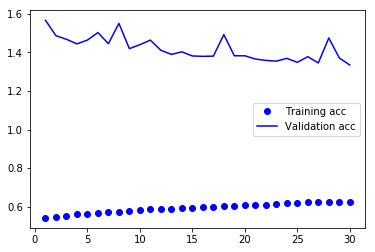

In [110]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.legend()

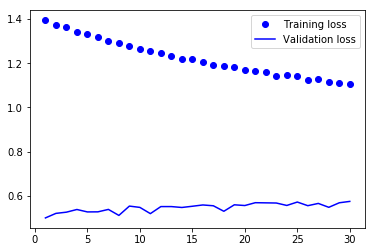

In [111]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.legend("Traning loss")
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.legend()

In [104]:
y_predict=model.predict(x_test)

In [105]:
y_predict_=np.argmax(y_predict,axis=1)
y_test_predict=np.argmax(y_test,axis=1)

In [106]:
L=list(encoder.inverse_transform(y_predict_))
K=list(encoder.inverse_transform(y_test_predict))

In [107]:
from sklearn.metrics import classification_report
print(classification_report(L,K))

                     precision    recall  f1-score   support

       agent handle       0.27      0.61      0.37        97
           approval       0.81      0.40      0.54      1531
         auto reply       0.38      0.53      0.44       165
       cancellation       0.03      0.14      0.05        35
       invoice copy       0.00      0.00      0.00         0
     itinerary copy       0.00      0.00      0.00         0
       modification       0.25      0.33      0.28       241
  new reseravation        0.21      0.34      0.26       197
request informaiton       0.00      0.00      0.00         3
          thank you       0.03      0.12      0.04        60
      undeliverable       0.95      0.96      0.96       293
             vendor       0.80      0.68      0.73      1024

          micro avg       0.52      0.52      0.52      3646
          macro avg       0.31      0.34      0.31      3646
       weighted avg       0.69      0.52      0.57      3646



# Hyper parameter tuning

In [113]:
import talos as ta

In [175]:
def LSTM_model(x_train,y_train,x_test,y_test,params):
    model=Sequential()
    model.add(Embedding(max_words,embedding_dim,input_length=maxlen))
    model.add(LSTM(20,recurrent_dropout=params['recurrent_dropout']))
    model.add(Dense(12,activation='softmax'))
    model.layers[0].set_weights([embedding_matrix])
    model.layers[0].trainable = False
    model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['acc'])
    out = model.fit(data,dummy_y,epochs=5,batch_size=params['batch_size'],validation_data=[x_test, y_test])
   
    return out,model
    

In [190]:
# first we have to make sure to input data and params into the function
def LSTM_model1(x_train, y_train, x_val, y_val, params):

    model = Sequential()
    model.add(Embedding(max_words,embedding_dim,input_length=maxlen))
    model.add(LSTM(params['first_neuron'],activation=params['activation'],kernel_initializer=params['kernel_initializer']))
    model.add(Dropout(params['dropout']))
    model.add(Dense(12, activation=params['last_activation'],kernel_initializer=params['kernel_initializer']))
    model.layers[0].set_weights([embedding_matrix])
    model.layers[0].trainable = False
    model.compile(loss=params['losses'],
                  optimizer=params['optimizer'](),
                  metrics=['acc', fmeasure_acc])
    
    history = model.fit(x_train, y_train, 
                        validation_data=[x_val, y_val],
                        batch_size=params['batch_size'],
                        callbacks=[live()],
                        epochs=params['epochs'],
                        verbose=0)

    return history, model



In [192]:
# then we can go ahead and set the parameter space
from keras.optimizers import Adam, Nadam
from keras.losses import categorical_crossentropy
from talos.metrics.keras_metrics import fmeasure_acc
from talos import live
from keras.activations import relu, elu
from keras.layers import Dropout, Dense
p = {'first_neuron':[9,10,11],
     'hidden_layers':[0, 1, 2],
     'batch_size': [30],
     'epochs': [10],
     'dropout': [0],
     'kernel_initializer': ['uniform','normal'],
     'optimizer': [Nadam,Adam],
     'losses': [categorical_crossentropy],
     'activation':[relu, elu],
     'last_activation': ['sigmoid']}



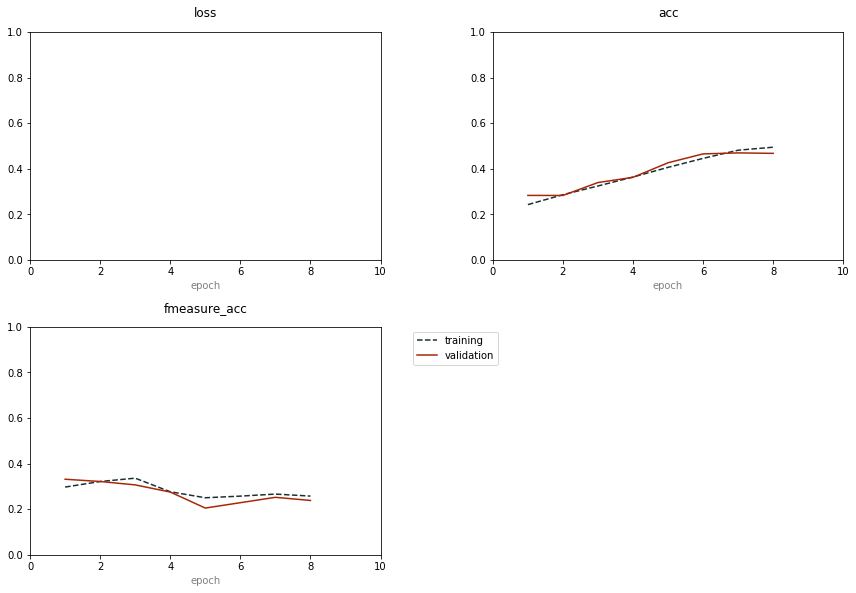

KeyboardInterrupt: 

In [193]:
# and run the experiment
t = ta.Scan(x=data,
            y=dummy_y,
            model=LSTM_model1,
            params=p,
            dataset_name='breast_cancer',
            experiment_no='1')

